In [14]:
import cv2  # For image processing
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import kagglehub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import f1_score
from kerastuner.tuners import Hyperband, RandomSearch

In [2]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    labels = []

    for label_folder in os.listdir(folder):
        # Skip hidden files and folders like .DS_Store
        if label_folder.startswith('.'):
            continue

        label_path = os.path.join(folder, label_folder)
        # Check if it's actually a directory
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    if label_folder == 'NORMAL':
                        labels.append(0)
                    else:
                        labels.append(1)

    return np.array(images), np.array(labels)

def flatten_images(images):
    n_samples = images.shape[0]
    return images.reshape((n_samples, -1))  # Flatten each image

In [5]:
train = '/content/drive/MyDrive/CS464 project/chest_xray/train'
val =  '/content/drive/MyDrive/CS464 project/chest_xray/val'
test = '/content/drive/MyDrive/CS464 project/chest_xray/test'

train_X, train_Y =load_images_from_folder(train, img_size=(128, 128))
val_X, val_Y =load_images_from_folder(val, img_size=(128, 128))
test_X, test_Y =load_images_from_folder(test, img_size=(128, 128))

train_X = flatten_images(train_X)
val_X = flatten_images(val_X)
test_X = flatten_images(test_X)

In [6]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#WE CREATED TEST IMAGES FROM THE TEST DATA AND TRAIN IMAGES FROM TRAIN DATA TO AVIOD BIAS.

train_generator = datagen.flow_from_directory(
    train,
    target_size=(128, 128),
    batch_size=10000,
    class_mode='binary',
    color_mode='grayscale'
)

Found 5239 images belonging to 2 classes.


In [7]:
combined_train_val_X = np.concatenate((val_X, train_X), axis=0)
combined_train_val_Y = np.concatenate((val_Y, train_Y), axis=0)

Created_train_X, Created_train_Y = next(train_generator)
Created_train_X = flatten_images(Created_train_X)
train_X = np.concatenate((Created_train_X, combined_train_val_X), axis=0)
train_Y = np.concatenate((Created_train_Y, combined_train_val_Y), axis=0)

In [8]:
train_X = train_X.reshape(-1, 128, 128, 1)/255.0
test_X = test_X.reshape(-1, 128, 128, 1)/255.0

In [10]:
# Function to tune layers, filters, kernels, and dropouts
def tune_model_structure():
    def build_model_structure(hp):
        model = Sequential()

        # Add convolutional layers with tunable parameters
        for i in range(hp.Int('num_conv_layers', 2, 4)):
            model.add(Conv2D(
                filters=hp.Choice(f'filters_{i}', values=[32, 64, 128]),
                kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
                activation=None,
                input_shape=(128, 128, 1) if i == 0 else None
            ))
            model.add(LeakyReLU(alpha=hp.Choice('leaky_relu_alpha', values=[0.01, 0.1])))
            model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())

        # Add dense layers with tunable parameters
        for i in range(hp.Int('num_dense_layers', 1, 2)):
            model.add(Dense(
                units=hp.Choice(f'units_dense_{i}', values=[64, 128, 256]),
                activation='relu'
            ))
            model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.2, max_value=0.5, step=0.1)))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    tuner = RandomSearch(
        build_model_structure,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuning_structure',
        project_name='structure_tuning'
    )

    tuner.search(train_X, train_Y, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters for model structure:")
    print(best_hps.values)

    return tuner

In [16]:
def tune_batch_size():
    def build_model_batch(hp):
        model = Sequential([
            Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.4),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    batch_sizes = [i for i in range(8, 65, 2)]
    batch_results = []

    for batch_size in batch_sizes:
        model = build_model_batch(None)
        history = model.fit(train_X, train_Y, validation_split=0.2, epochs=10, batch_size=batch_size, verbose=1)
        val_accuracy = max(history.history['val_accuracy'])
        batch_results.append((batch_size, val_accuracy))

    best_batch_size = max(batch_results, key=lambda x: x[1])[0]
    print(f"Best batch size: {best_batch_size}")

    return batch_results

Reloading Tuner from tuning_structure/structure_tuning/tuner0.json
Best hyperparameters for model structure:
{'num_conv_layers': 4, 'filters_0': 64, 'kernel_size_0': 5, 'leaky_relu_alpha': 0.01, 'filters_1': 128, 'kernel_size_1': 5, 'num_dense_layers': 2, 'units_dense_0': 256, 'dropout_rate_0': 0.4, 'filters_2': 32, 'kernel_size_2': 3, 'filters_3': 64, 'kernel_size_3': 5, 'units_dense_1': 64, 'dropout_rate_1': 0.30000000000000004}
Epoch 1/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8302 - loss: 0.5729 - val_accuracy: 0.3759 - val_loss: 1.3136
Epoch 2/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8553 - loss: 0.3016 - val_accuracy: 0.4165 - val_loss: 1.3737
Epoch 3/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8944 - loss: 0.2419 - val_accuracy: 0.5844 - val_loss: 0.9380
Epoch 4/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9176 - loss: 0.1988 - val_accuracy: 0.7461 - val_loss: 0.6569
Epoch 5/10
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 4s 

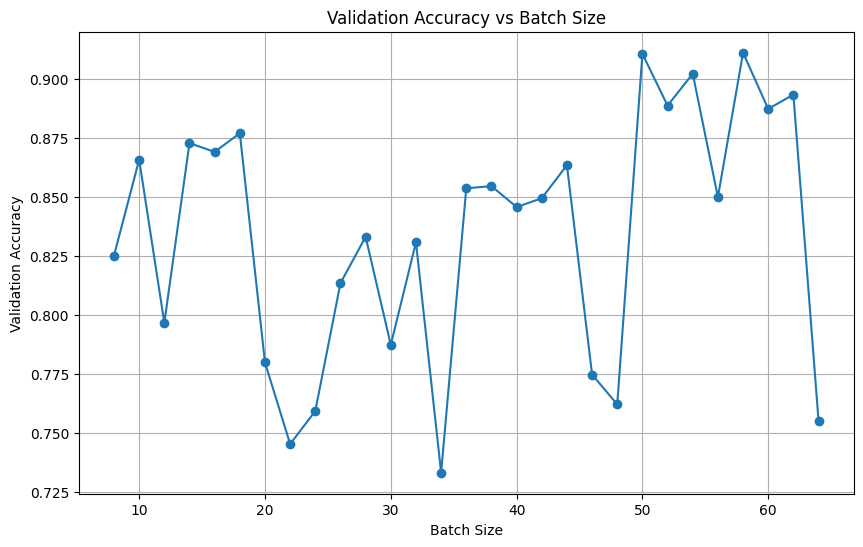

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8245 - loss: 0.4755 - val_accuracy: 0.4399 - val_loss: 1.1193
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8423 - loss: 0.3518 - val_accuracy: 0.5110 - val_loss: 0.9889
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8741 - loss: 0.2965 - val_accuracy: 0.6554 - val_loss: 0.6195
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8957 - loss: 0.2532 - val_accuracy: 0.6648 - val_loss: 0.5937
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9044 - loss: 0.2243 - val_accuracy: 0.6597 - val_loss: 0.6233
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9157 - loss: 0.2033 - val_accuracy: 0.6606 - val_loss: 0.7711
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9202 - loss: 0.1845 - val_accuracy: 0.5250 - val_loss: 0.9239
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9311 - loss: 0.1638 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8270 - loss: 0.4481 - val_accuracy: 0.4446 - val_loss: 1.0147
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8706 - loss: 0.2841 - val_accuracy: 0.7564 - val_loss: 0.5437
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9129 - loss: 0.2121 - val_accuracy: 0.4254 - val_loss: 1.2312
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9143 - loss: 0.1924 - val_accuracy: 0.4072 - val_loss: 0.9658
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9470 - loss: 0.1411 - val_accuracy: 0.6886 - val_loss: 0.6041
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9551 - loss: 0.1131 - val_accuracy: 0.5867 - val_loss: 0.9791
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9655 - loss: 0.0837 - val_accuracy: 0.6643 - val_loss: 0.8179
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9829 - loss: 0.0478 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8287 - loss: 0.4212 - val_accuracy: 0.3890 - val_loss: 1.4836
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8915 - loss: 0.2453 - val_accuracy: 0.5372 - val_loss: 0.6605
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9075 - loss: 0.2213 - val_accuracy: 0.7302 - val_loss: 0.5539
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9267 - loss: 0.1773 - val_accuracy: 0.6793 - val_loss: 0.8189
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9445 - loss: 0.1469 - val_accuracy: 0.5138 - val_loss: 1.0822
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9576 - loss: 0.1044 - val_accuracy: 0.4792 - val_loss: 1.2526
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9736 - loss: 0.0758 - val_accuracy: 0.5348 - val_loss: 1.5621
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9837 - loss: 0.0500 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8002 - loss: 0.5039 - val_accuracy: 0.3731 - val_loss: 0.9534
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8435 - loss: 0.3345 - val_accuracy: 0.3997 - val_loss: 0.9680
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8655 - loss: 0.3018 - val_accuracy: 0.4469 - val_loss: 1.0427
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8860 - loss: 0.2599 - val_accuracy: 0.5372 - val_loss: 0.8725
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9066 - loss: 0.2174 - val_accuracy: 0.5947 - val_loss: 0.8447
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9214 - loss: 0.1891 - val_accuracy: 0.7401 - val_loss: 0.5618
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9327 - loss: 0.1644 - val_accuracy: 0.7195 - val_loss: 0.6166
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9442 - loss: 0.1354 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8214 - loss: 0.4544 - val_accuracy: 0.3754 - val_loss: 1.1005
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8430 - loss: 0.3330 - val_accuracy: 0.5297 - val_loss: 0.9275
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8646 - loss: 0.2884 - val_accuracy: 0.4610 - val_loss: 1.1923
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8959 - loss: 0.2574 - val_accuracy: 0.7368 - val_loss: 0.6214
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9065 - loss: 0.2121 - val_accuracy: 0.6877 - val_loss: 0.6822
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9384 - loss: 0.1602 - val_accuracy: 0.5750 - val_loss: 0.8721
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9453 - loss: 0.1414 - val_accuracy: 0.6924 - val_loss: 0.6244
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9580 - loss: 0.1046 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8143 - loss: 0.4778 - val_accuracy: 0.3731 - val_loss: 1.4920
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8373 - loss: 0.3674 - val_accuracy: 0.4656 - val_loss: 0.7898
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8433 - loss: 0.3469 - val_accuracy: 0.4871 - val_loss: 1.3304
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8818 - loss: 0.2765 - val_accuracy: 0.6344 - val_loss: 0.8230
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8955 - loss: 0.2407 - val_accuracy: 0.6288 - val_loss: 0.6998
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9188 - loss: 0.1996 - val_accuracy: 0.8298 - val_loss: 0.4236
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9242 - loss: 0.1847 - val_accuracy: 0.7391 - val_loss: 0.5694
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9372 - loss: 0.1542 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8119 - loss: 0.4399 - val_accuracy: 0.3759 - val_loss: 1.6662
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8492 - loss: 0.3388 - val_accuracy: 0.4030 - val_loss: 1.3374
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8741 - loss: 0.2833 - val_accuracy: 0.5049 - val_loss: 0.8975
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9049 - loss: 0.2235 - val_accuracy: 0.7990 - val_loss: 0.4947
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9184 - loss: 0.1913 - val_accuracy: 0.7186 - val_loss: 0.5828
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9336 - loss: 0.1589 - val_accuracy: 0.5596 - val_loss: 0.7794
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9413 - loss: 0.1453 - val_accuracy: 0.6872 - val_loss: 0.8146
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9471 - loss: 0.1172 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8167 - loss: 0.4738 - val_accuracy: 0.3735 - val_loss: 1.0077
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8365 - loss: 0.3706 - val_accuracy: 0.3894 - val_loss: 2.1098
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8720 - loss: 0.2866 - val_accuracy: 0.5802 - val_loss: 0.6820
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8971 - loss: 0.2409 - val_accuracy: 0.6966 - val_loss: 0.5502
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9050 - loss: 0.2284 - val_accuracy: 0.6381 - val_loss: 0.6827
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9204 - loss: 0.1937 - val_accuracy: 0.7129 - val_loss: 0.6046
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9222 - loss: 0.1771 - val_accuracy: 0.6381 - val_loss: 0.8012
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9309 - loss: 0.1709 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8003 - loss: 0.4407 - val_accuracy: 0.5395 - val_loss: 0.6875
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8696 - loss: 0.2924 - val_accuracy: 0.3885 - val_loss: 1.2341
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8966 - loss: 0.2377 - val_accuracy: 0.4203 - val_loss: 1.2795
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9139 - loss: 0.1980 - val_accuracy: 0.6241 - val_loss: 0.8098
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9233 - loss: 0.1796 - val_accuracy: 0.5858 - val_loss: 0.9004
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9386 - loss: 0.1440 - val_accuracy: 0.5451 - val_loss: 1.0503
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9440 - loss: 0.1278 - val_accuracy: 0.6798 - val_loss: 0.6865
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9671 - loss: 0.0898 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8212 - loss: 0.4688 - val_accuracy: 0.3740 - val_loss: 1.1379
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8325 - loss: 0.3800 - val_accuracy: 0.3740 - val_loss: 1.4177
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8476 - loss: 0.3369 - val_accuracy: 0.3876 - val_loss: 1.0745
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8558 - loss: 0.3164 - val_accuracy: 0.3731 - val_loss: 1.9135
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8344 - loss: 0.4114 - val_accuracy: 0.3978 - val_loss: 0.7023
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8430 - loss: 0.3418 - val_accuracy: 0.3759 - val_loss: 1.0053
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8529 - loss: 0.3213 - val_accuracy: 0.4278 - val_loss: 1.0208
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8606 - loss: 0.2956 - val_accuracy: 0

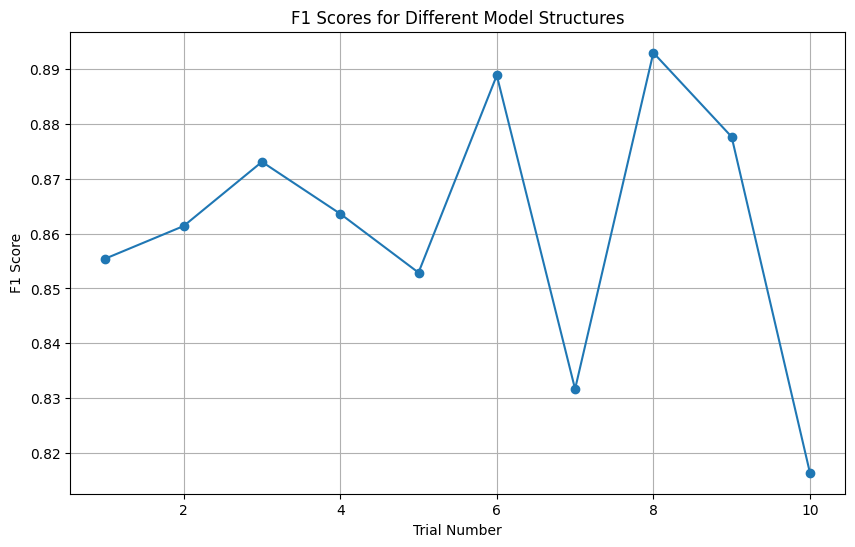

In [17]:
# Plot results
def plot_tuning_results(batch_results, structure_tuner):
    # Plot batch size results
    batch_sizes, accuracies = zip(*batch_results)
    plt.figure(figsize=(10, 6))
    plt.plot(batch_sizes, accuracies, marker='o')
    plt.title('Validation Accuracy vs Batch Size')
    plt.xlabel('Batch Size')
    plt.ylabel('Validation Accuracy')
    plt.grid()
    plt.show()

    # Plot structure tuning results
    trials = structure_tuner.oracle.get_best_trials(num_trials=10)
    f1_scores = []

    for trial in trials:
        hps = trial.hyperparameters
        temp_model = structure_tuner.hypermodel.build(hps)
        temp_model.fit(train_X, train_Y, validation_split=0.2, epochs=10, batch_size=32, verbose=1)
        y_pred = temp_model.predict(test_X)
        y_pred_classes = (y_pred > 0.5).astype('int32')
        temp_f1 = f1_score(test_Y, y_pred_classes)
        f1_scores.append(temp_f1)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
    plt.title('F1 Scores for Different Model Structures')
    plt.xlabel('Trial Number')
    plt.ylabel('F1 Score')
    plt.grid()
    plt.show()

# Execute all tuning and plotting steps
def execute_tuning_and_plotting():
    structure_tuner = tune_model_structure()
    batch_results = tune_batch_size()
    plot_tuning_results(batch_results, structure_tuner)

# Call the execution function
execute_tuning_and_plotting()